In [67]:
%reload_ext autoreload
%autoreload 2

/home/neba/Desktop/heart-disease-pred/week0-starter-network-analysis/src/preprocessing.py:33: DeprecationWarning: invalid escape sequence \d
  return sub('[.:;()/!&-*@$,?^\d+]', '', myWord)
/home/neba/Desktop/heart-disease-pred/week0-starter-network-analysis/src/preprocessing.py:121: DeprecationWarning: invalid escape sequence \w
  self.df[new_col] = self.df[org_col].str.replace('[^\w\s]', '')
/home/neba/Desktop/heart-disease-pred/week0-starter-network-analysis/src/preprocessing.py:122: DeprecationWarning: invalid escape sequence \w
  self.df[new_col] = self.df[new_col].str.replace('\w*\d\w*', '')
[nltk_data] Downloading package wordnet to /home/neba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/neba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/neba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package

In [30]:

import os
import sys
import seaborn as sns

# import pyLDAvis
import pyLDAvis.gensim_models

import numpy as np

import pandas as pd
from gensim import corpora, models
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

In [31]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [32]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/neba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/neba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
from src.preprocessing import Preprocessing

In [34]:
# Initialize DataLoader
sl = SlackDataLoader('../Anonymized_B6SlackExport_25Nov23/anonymized/')

In [35]:
# converting all json files for all-community-building channel to dataframe using slack_parser method from loader script
df_community = sl.slack_parser('../Anonymized_B6SlackExport_25Nov23/anonymized/all-community-building/')

### plot histogram of the time difference between Consecutive messages


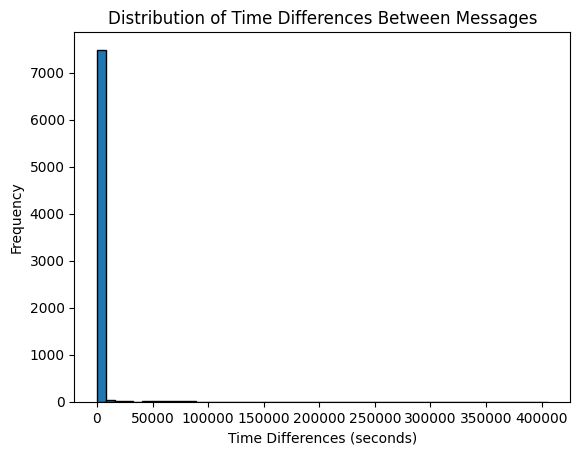

In [36]:
# Convert 'message_sent_time' to datetime format
# df['message_sent_time'] = pd.to_datetime(df['message_sent_time'])
df_community['msg_sent_time'] = pd.to_datetime(df_community['msg_sent_time'], unit='s')

# Sort the DataFrame by 'message_sent_time'
df_community = df_community.sort_values(by='msg_sent_time')

# Calculate time differences between consecutive messages
df_community['time_difference'] = df_community['msg_sent_time'].diff()

# Plot the distribution of time differences
plt.hist(df_community['time_difference'].dt.total_seconds(), bins=50, edgecolor='black')
plt.xlabel('Time Differences (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences Between Messages')
plt.show()


### Plot a histogram of the time difference between Consecutive replies

### We will generate a histogram illustrating the time differences between consecutive replies for message with the highest reply count.

In [37]:
# Find the index of the maximum reply_count
max_reply_count= df_community['reply_count'].max()
max_reply_count

75

##### let's get the message with the highest reply count(75)

In [38]:
msg_content = sl.get_channel_messages(channel_name='all-community-building')

In [39]:
def filter_msg(msg_content):
    
    for msg in msg_content:
        if 'reply_count' in msg.keys():
            if msg['reply_count']==75:
                return msg

In [40]:
top_reply_count_message = filter_msg(msg_content)

In [41]:
# convery replies key to a dataframe
df_replies = pd.DataFrame(top_reply_count_message['replies'])

In [42]:
df_replies.columns

Index(['user', 'ts'], dtype='object')

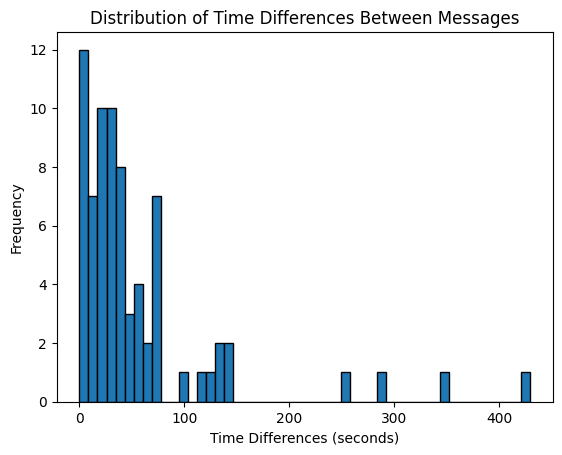

In [43]:
df_replies['ts'] = pd.to_datetime(df_replies['ts'], unit='s')

# Sort the DataFrame by 'message_sent_time'
df_replies = df_replies.sort_values(by='ts')

# Calculate time differences between consecutive messages
df_replies['time_difference'] = df_replies['ts'].diff()

# Plot the distribution of time differences
plt.hist(df_replies['time_difference'].dt.total_seconds(), bins=50, edgecolor='black')
plt.xlabel('Time Differences (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences Between Messages')
plt.show()


In [44]:
!pip3 install gensim
!pip3 install pyLDAvis

In [45]:
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from gensim.utils import SaveLoad
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from re import sub
import pyLDAvis
from collections import Counter
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from wordcloud import WordCloud
from sklearn.utils import resample

In [46]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [47]:
df_community.head()

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,time_difference
7511,message,"Hi all, looking forward to starting together, ...",Katherine Foster,2022-08-21 15:15:57.241138935,text,0,0,0,0,0,,NaT
7512,message,Hello everyone. It's my hope that you are doin...,Vanessa Norman,2022-08-22 06:54:04.337328911,text,0,0,0,0,0,,0 days 15:38:07.096189976
5364,message,*Community Building Session REMINDER!*:timer_c...,Vanessa Norman,2022-08-22 11:50:00.633059025,text,1661169000.633059,3,2,"U03UG0YHAUT,U03V1AM5TFA",1661169624.405079,,0 days 04:55:56.295730114
5365,message,Let's get ready to the first CBS of the progra...,Daniel Brown,2022-08-22 11:57:41.106858969,text,1661169000.633059,0,0,0,0,,0 days 00:07:40.473799944
5366,message,The very first CBS is here,Vanessa Norman,2022-08-22 11:59:07.570658922,text,1661169000.633059,0,0,0,0,,0 days 00:01:26.463799953


In [48]:
preprocess = Preprocessing(df_community)

In [49]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# clean text 
df_community = preprocess.cleantext('msg_content', 'clean_msg_content')

# Stem words
df_community = preprocess.stem('clean_msg_content')

/home/neba/Desktop/heart-disease-pred/week0-starter-network-analysis/src/preprocessing.py:110: FutureWarning: The default value of regex will change from True to False in a future version.
  """Clean text.
/home/neba/Desktop/heart-disease-pred/week0-starter-network-analysis/src/preprocessing.py:111: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [50]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/neba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/neba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
# Used stemmer instead of lemmatizer
cleanKagslacklist = preprocess.filterSlackList(df_community['clean_msg_content'])

In [70]:
cleanKagslacklist[1]

['hello',
 'everyon',
 'hope',
 'great',
 'start',
 'today',
 'great',
 'great',
 'great',
 'thing',
 'prepar',
 'usual',
 None,
 'channel',
 'commun',
 'build',
 'session',
 'cb',
 'wait',
 'hot',
 'cake',
 'back',
 'hugging_fac',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [53]:
def makeDict(mySlackList):
    """Create dictionary from list of tokenized documents"""
    return corpora.Dictionary(mySlackList)

def makeCorpus(mySlackList,myDict):
    """Create corpus from list of tokenized documents"""
    return [myDict.doc2bow(slackmessage) for slackmessage in mySlackList]

def createLDA(myCorpus, myDictionary,myTopics=50,myPasses=10,myIterations=50,myAlpha=0.001):
    """LDA model call function"""
    return models.LdaMulticore(myCorpus, id2word=myDictionary, num_topics=myTopics, passes=myPasses,
    iterations=myIterations,alpha=myAlpha)

In [54]:
"""Create model objects"""
kagDict   = makeDict(cleanKagslacklist)
kagCorpus = makeCorpus(cleanKagslacklist, kagDict)
kagLda = createLDA(kagCorpus, kagDict)

"""Save model objects"""
SaveLoad.save(kagLda,'kaggleLDAmodel')
corpora.MmCorpus.serialize('kaggleCorpus.mm', kagCorpus)
kagDict.save('kaggleDictionary.dict')

In [55]:
kagLda = SaveLoad.load('kaggleLDAmodel')
kagDict = corpora.Dictionary.load('kaggleDictionary.dict')
kagCorpus = corpora.MmCorpus('kaggleCorpus.mm')

In [56]:
pyLDAvis.enable_notebook()
ldaViz = pyLDAvis.gensim_models.prepare(kagLda, kagCorpus, kagDict)

/home/neba/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [57]:
kagLda.print_topics()

[(21,
  '0.103*"session" + 0.076*"pm" + 0.066*"plea" + 0.064*"next" + 0.064*"cb" + 0.052*"time" + 0.048*"commun" + 0.041*"note" + 0.039*"utc" + 0.039*"build"'),
 (44,
  '0.102*"happi" + 0.067*"birthday" + 0.062*"arsen" + 0.037*"fan" + 0.017*"mom" + 0.017*"take" + 0.017*"thought" + 0.015*"alway" + 0.012*"day" + 0.012*"hahahahah"'),
 (46,
  '0.185*"joy" + 0.022*"captain" + 0.021*"question" + 0.017*"love" + 0.015*"hate" + 0.015*"america" + 0.011*"come" + 0.009*"get" + 0.009*"war" + 0.008*"civil"'),
 (34,
  '0.049*"war" + 0.046*"like" + 0.031*"favorit" + 0.031*"song" + 0.030*"star" + 0.027*"week" + 0.027*"phone" + 0.021*"perform" + 0.019*"movi" + 0.014*"complet"'),
 (35,
  '0.038*"join" + 0.016*"get" + 0.016*"window" + 0.015*"child" + 0.015*"alon" + 0.013*"dont" + 0.012*"listen" + 0.012*"special" + 0.011*"nahom" + 0.011*"dictionari"'),
 (29,
  '0.040*"said" + 0.025*"someon" + 0.023*"blush" + 0.020*"like" + 0.018*"one" + 0.015*"mood" + 0.014*"ever" + 0.012*"yet" + 0.011*"post" + 0.011*"youg

In [58]:
def translateLdaIdx(myLdaModel, myLdaViz):
    """Translate lda model topics to match the topics in pyLDAvis visualization"""
    ldaVizIdx = myLdaViz[0].index
    return list(ldaVizIdx)

In [59]:
newIdx = translateLdaIdx(kagLda,ldaViz)

In [60]:
def createDenseMat(myLdaModel,myCorpus,newIdx):
    """Transform corpus to dataframe with topics matching lda visualization"""
    numTopics = myLdaModel.num_topics
    myDense = corpus2dense(myLdaModel[myCorpus],numTopics)
    myDf = pd.DataFrame(myDense)
    mySortedDf = myDf.transpose()
    mySortedDf = myDf.transpose()[newIdx]
    mySortedDf.columns = ['topic' + str(i + 1) for i in range(numTopics)]
    return mySortedDf

In [61]:
kagDf = createDenseMat(kagLda,kagCorpus,newIdx)

In [62]:
def sortByTopicToIdx(cleanKagslacklist,mySortedDf,myTopic,myTopicThresh=0.1):
    """Returns an index of tweets surpassing a topic value threshold"""
    srtIdx = list(mySortedDf[mySortedDf[myTopic]>myTopicThresh].index)
    return srtIdx

def sortSlackByIdx(cleanKagslacklist,srtIdx):
    """Returns sorted tweets as a list based on a defined sort index"""
    myCleanArray = np.array(cleanKagslacklist)
    srtTweets = list(myCleanArray[srtIdx])
    return srtTweets

In [63]:
sortedIdx = sortByTopicToIdx(cleanKagslacklist,kagDf,'topic2',myTopicThresh=0.1)

In [64]:
# Word cloud for topic 
def makeWordCloud(cleanKagslacklist,mySortedDf,myTopic,myTopicThresh=0.1):
    """Create word cloud of tweets passing a given threshold for a given topic"""
    sortedIdx = sortByTopicToIdx(cleanKagslacklist,mySortedDf,myTopic,myTopicThresh=0.1)
    mySortedSlack = sortSlackByIdx(cleanKagslacklist,sortedIdx)
    filteredWords = ' '.join([' '.join(filter(None, string)) for string in mySortedSlack])
    myTopicCloud = WordCloud(width=800, height=800, max_font_size=100, scale=8).generate(filteredWords)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 10), dpi=1600)
    plt.imshow(myTopicCloud)
    plt.axis("off")  # Turn off axis labels
    plt.show()


In [65]:
def makeWordCloud(cleanKagslacklist, mySortedDf, myTopic, myTopicThresh=0.1):
    """Create word cloud of tweets passing a given threshold for a given topic"""
    sortedIdx = sortByTopicToIdx(cleanKagslacklist, mySortedDf, myTopic, myTopicThresh=0.1)
    mySortedSlack = sortSlackByIdx(cleanKagslacklist, sortedIdx)
    filteredWords = ' '.join([' '.join(filter(None, string)) for string in mySortedSlack])
    myTopicCloud = WordCloud(width=800, height=800, max_font_size=100, scale=8).generate(filteredWords)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(myTopicCloud)
    plt.axis("off")  # Turn off axis labels
    plt.show()

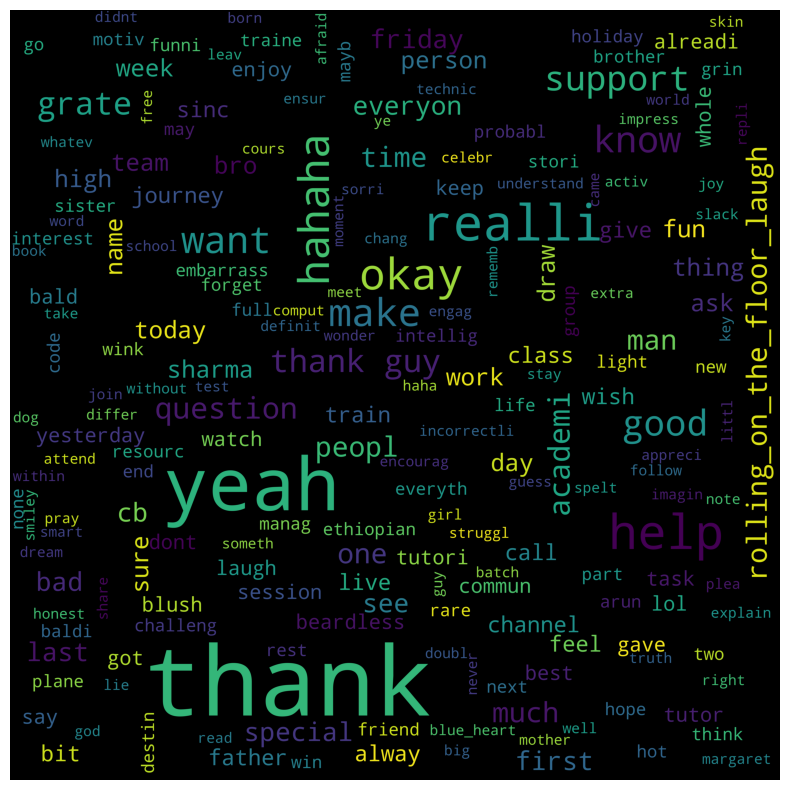

In [71]:
makeWordCloud(cleanKagslacklist,kagDf,'topic2',myTopicThresh=0.2)